In [1]:
%matplotlib inline

In [2]:
from Bio import SeqIO
import json
import numpy as np
import random

from matplotlib import pyplot as plt
from scipy import stats
from collections import Counter

import re

import pandas as pd

In [3]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 9
matplotlib.rcParams['ytick.labelsize'] = 9
matplotlib.rcParams['axes.labelsize'] = 9
matplotlib.rcParams['axes.titlesize'] = 10

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.8'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5


matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.weight']='ultralight'
matplotlib.rcParams['axes.axisbelow'] = True

In [82]:
include = 20
utr_dicty = {}
seq_dicty = {}
genome = list(SeqIO.parse('/Users/adamhockenberry/Projects/2017/Genome_database/Data/GBFs/511145.12.PATRIC.gbf', 'genbank'))
# genome = list(SeqIO.parse('/Users/adamhockenberry/Projects/OpenBiology_2016/Data/genomes/NA1000_JMS.gbk', 'genbank'))
# genome = list(SeqIO.parse('/Users/adamhockenberry/Projects/OpenBiology_2016/Data/genomes/bacillus.gb', 'genbank'))


for record in genome:
    for feature in record.features[:]:
        if feature.type == 'CDS':
            if feature.location.strand == 1:
                cds = str(record.seq[feature.location.start:feature.location.end])
            elif feature.location.strand == -1:
                cds = str(record.seq[feature.location.start:feature.location.end].reverse_complement())
            if len(cds)%3 != 0 or len(cds) < 180 or len(cds) > 3000 or cds[-3:] not in ['TAA', 'TGA', 'TAG']:
                continue
            if cds.count('A') + cds.count('T') +cds.count('G') +cds.count('C') != len(cds):
                continue
            codons = [str(cds)[i:i+3] for i in range(0, len(cds), 3)]
            if codons[:-1].count('TAG') + codons[:-1].count('TGA') + codons[:-1].count('TAA') != 0:
                continue
            name = feature.qualifiers['locus_tag'][0]
            if feature.location.strand == 1:
                utr_dicty[name] = record.seq[feature.location.start-include:feature.location.start]
            elif feature.location.strand == -1:
                utr_dicty[name] = record.seq[feature.location.end:feature.location.end+include].reverse_complement()
            seq_dicty[name] = cds

In [83]:
nt_seqs = list(seq_dicty.values())
print(len(nt_seqs))

4127


In [76]:
with open('../Data/json-energyRef-CCUCCU.txt', 'r') as infile:
    fragment_energy_dict = json.load(infile)
asd_seq = 'CCUCCU'

In [77]:
ignore_last_x = 59 ###To ignore 60, make these 59
ignore_first = 59
energy_seqs = []
for nt_sequence in nt_seqs:
    energy_list = []
    for i in range(ignore_first, len(nt_sequence)-len(asd_seq)-ignore_last_x):
        fragment = nt_sequence[i:i+len(asd_seq)]
        energy = fragment_energy_dict[fragment.replace('T', 'U')]
        energy_list.append(energy)
    energy_seqs.append(energy_list)

In [80]:
windows_to_search = []
for i in range(0, 16, 2):
    windows_to_search.append((i,i+6))

thresh = -7.5

results_dicty_actual = {}
results_dicty_control = {}

randomizations = 5

for window_to_search in windows_to_search:
    putative_starts = []
    sd_counts_per_gene = []
    for i, energy_list in enumerate(energy_seqs):
        sd_counts = 0
        for pos,energy in enumerate(energy_list):
            if pos == 0:
                continue
            if pos == len(energy_list)-1:
                continue
            if energy < thresh and energy <= energy_list[pos-1] and energy < energy_list[pos+1]:
                sd_counts += 1
                fragment = nt_seqs[i][pos+ignore_first+len(asd_seq)+window_to_search[0]:\
                                      pos+ignore_first+len(asd_seq)+window_to_search[1]]
                assert len(fragment)==6
                if 'ATG' in fragment:
                    position = fragment.index('ATG')
                    absolute_position = pos+ignore_first+len(asd_seq)+window_to_search[0]+position
                    putative_starts.append(absolute_position)
        sd_counts_per_gene.append(sd_counts)
    print(window_to_search, np.sum(sd_counts_per_gene))
    
    control_starts_matrix = []
    for randomization in range(randomizations):
        control_starts = []
        for i, sd_counts in enumerate(sd_counts_per_gene):
            if sd_counts > 0:
                positions_to_test = np.random.choice(list(range(len(energy_seqs[i]))), replace=False, size=sd_counts)
                for pos in positions_to_test:
                    fragment = nt_seqs[i][pos+ignore_first+len(asd_seq)+window_to_search[0]:\
                                          pos+ignore_first+len(asd_seq)+window_to_search[1]]
                    if 'ATG' in fragment:
                        position = fragment.index('ATG')
                        absolute_position = pos+ignore_first+len(asd_seq)+window_to_search[0]+position
                        control_starts.append(absolute_position)
        control_starts_matrix.append(control_starts)
    

    results_dicty_actual[window_to_search] = putative_starts
    results_dicty_control[window_to_search] = control_starts_matrix

(0, 6) 3370
(2, 8) 3370
(4, 10) 3370
(6, 12) 3370
(8, 14) 3370
(10, 16) 3370
(12, 18) 3370
(14, 20) 3370


(0, 6) -10.1702676186 2.69168100319e-24 0.788079470199
(2, 8) -4.27111887432 1.94494693889e-05 0.792639773531
(4, 10) -2.45760823784 0.0139865656351 0.800561797753
(6, 12) -6.03825583083 1.55788936342e-09 0.744234800839
(8, 14) -1.57235814196 0.115867516019 0.908759124088
(10, 16) -1.69476248805 0.0901204862098 0.9140969163
(12, 18) -3.57236059809 0.0003537778132 0.803389830508
(14, 20) -1.14276008905 0.253138213662 0.95966620306


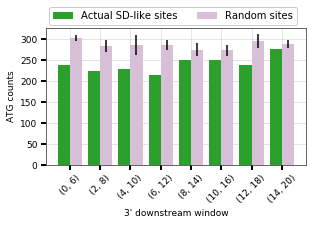

In [81]:
n = len(windows_to_search)
actual_vals = [len(results_dicty_actual[window]) for window in windows_to_search]
control_vals_mean = []
control_vals_stdev = []
for window in windows_to_search:
    tempy = []
    for i in range(randomizations):
        tempy.append(len(results_dicty_control[window][i]))
    control_vals_mean.append(np.mean(tempy))
    control_vals_stdev.append(np.std(tempy))
    
for i in range(len(actual_vals)):
    zscore = (actual_vals[i]-control_vals_mean[i])/control_vals_stdev[i]
    print(windows_to_search[i], zscore, stats.norm.sf(abs(zscore))*2, actual_vals[i]/control_vals_mean[i])


plot_indices = np.arange(n)
width = 0.4

fig, ax = plt.subplots(figsize=(4.5,3))
rects1 = ax.bar(plot_indices, actual_vals, width, color='#2ca02c') 
rects2 = ax.bar(plot_indices+width, control_vals_mean, width, yerr=control_vals_stdev, color='thistle') 

ax.set_xticks(plot_indices + width/2)
ax.set_xticklabels(windows_to_search, rotation=45)
ax.set_ylabel('ATG counts')
ax.set_xlabel('3\' downstream window')
legend = ax.legend((rects1[0], rects2[0]), ('Actual SD-like sites', 'Random sites'),\
                   fontsize=10, loc=3, bbox_to_anchor=(0.01, 1.02, 1., .102), ncol=2, borderaxespad=0.)
legend.get_frame().set_alpha(1)
# ax.set_ylim(0, 2000)
plt.tight_layout()
# plt.savefig('../Results/Figures/start_codon_frequency.pdf', bbox_inches='tight')
# plt.savefig('/Users/adamhockenberry/Desktop/Caulo_start_codon_and_SD_thresh=-8.5.pdf', bbox_inches='tight')

# Null expectation about total number of SD genes and SD-like counts throughout the *E. coli* genome

In [11]:
from Bio.Data import CodonTable

def get_codon_dicts(n=11):
    '''
    This function outputs two dictionaries to convert between amino acids and codons and vice versa.
    No necessary imports unless you want to use a strange genetic code table.
    '''
    GivenCodonTable = CodonTable.unambiguous_dna_by_id[n]
    nucleotides = ['A', 'T', 'G', 'C']
    aa_to_codons = {}
    for first in nucleotides:
        for second in nucleotides:
            for third in nucleotides:
                Codon = first + second + third
                if Codon not in CodonTable.unambiguous_dna_by_id[n].stop_codons:
                    if GivenCodonTable.forward_table[Codon] in aa_to_codons.keys():
                            aa_to_codons[GivenCodonTable.forward_table[Codon]].append(Codon)
                    else:
                        aa_to_codons[GivenCodonTable.forward_table[Codon]] = [Codon]
                else:
                    pass
    codon_to_aa = {}
    for aa, syns in aa_to_codons.items():
        for syn in syns:
            codon_to_aa[syn] = aa
    return aa_to_codons, codon_to_aa

def shuffle_gene_synonymous(gene_sequence_codons, aa_to_codons_dict, codon_to_aa_dict):
    '''
    This is my randomization procedure that I think is pretty efficient.
    What it does is essentially break every 'gene_sequence_codons' list down into a dictionary ("temp_dict")
    that has key:val of "amino acid":"list of all codons used in sequence for that amino acid". Then shuffles
    those resulting lists and re-codes the original gene_sequence_codons
    '''
    shuffled_sequence_codons = []
    temp_dict = {}
    for aa in aa_to_codons_dict:
        temp_dict[aa] = []
    for codon in gene_sequence_codons:
        temp_dict[codon_to_aa_dict[codon]].append(codon)
    for aa, synon_codons in temp_dict.items():
        np.random.shuffle(synon_codons)
    for codon in gene_sequence_codons:
        shuffled_sequence_codons.append(temp_dict[codon_to_aa_dict[codon]].pop())
    return shuffled_sequence_codons

aa_to_codons_dict, codon_to_aa_dict = get_codon_dicts()

## First get coding sequence and 5' UTR dictionaries

In [11]:
include = 20
utr_dicty = {}
seq_dicty = {}


# genome = list(SeqIO.parse('/Users/adamhockenberry/Projects/2017/Genome_database/Data/GBFs/511145.12.PATRIC.gbf', 'genbank'))
for record in genome:
    for feature in record.features[:]:
        if feature.type == 'CDS':
            if feature.location.strand == 1:
                cds = str(record.seq[feature.location.start:feature.location.end])
            elif feature.location.strand == -1:
                cds = str(record.seq[feature.location.start:feature.location.end].reverse_complement())
            if len(cds)%3 != 0 or len(cds) < 180 or len(cds) > 3000 or cds[-3:] not in ['TAA', 'TGA', 'TAG']:
                continue
            if cds.count('A') + cds.count('T') +cds.count('G') +cds.count('C') != len(cds):
                continue
            codons = [str(cds)[i:i+3] for i in range(0, len(cds), 3)]
            if codons[:-1].count('TAG') + codons[:-1].count('TGA') + codons[:-1].count('TAA') != 0:
                continue
            name = feature.qualifiers['locus_tag'][0]
            if feature.location.strand == 1:
                utr_dicty[name] = record.seq[feature.location.start-include:feature.location.start]
            elif feature.location.strand == -1:
                utr_dicty[name] = record.seq[feature.location.end:feature.location.end+include].reverse_complement()
            seq_dicty[name] = cds

In [12]:
print(len(seq_dicty.keys()), len(utr_dicty.keys()))

3703 3703


## Now assess SD sequence usage in the UTRs

In [13]:
with open('../Data/json-energyRef-CCUCCU.txt') as infile:
    fragment_energy_dict = json.load(infile)
asd_seq = 'CCTCCT'

In [14]:
# randomizations = 100
randomizations = 2
real_utrs = [str(j) for i,j in utr_dicty.items()]

strongest_real = []
strongest_fake_all = []
strongest_fake_dict = {}
for randomization in range(randomizations):
    strongest_fake_dict[randomization] = []


for utr in real_utrs[:]:
    energy_list = []
    for i in range(0, len(utr)-len(asd_seq)-4):
        fragment = utr[i:i+len(asd_seq)]
        energy = fragment_energy_dict[fragment.replace('T', 'U')]
        energy_list.append(energy)
    strongest_real.append(min(energy_list))
    
    for randomization in range(randomizations):
        energy_list = []
        utr_rand = np.array(list(utr))
        np.random.shuffle(utr_rand)
        utr_rand = ''.join(list(utr_rand))
        for i in range(0, len(utr_rand)-len(asd_seq)-4):
            fragment = utr_rand[i:i+len(asd_seq)]
            energy = fragment_energy_dict[fragment.replace('T', 'U')]
            energy_list.append(energy)
        strongest_fake_all.append(min(energy_list))
        strongest_fake_dict[randomization].append(min(energy_list))        

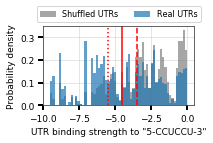

In [15]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
ax.hist(strongest_fake_all, 60, normed=True, alpha=0.7, color='gray', label='Shuffled UTRs')
ax.hist(strongest_real, 60, normed=True, alpha=0.7, label='Real UTRs')
ax.axvline(-4.5, c='r')
ax.axvline(-3.5, c='r', linestyle='--')
ax.axvline(-5.5, c='r', linestyle=':')
ax.set_xlabel('UTR binding strength to "5-CCUCCU-3"')
ax.set_ylabel('Probability density')
fig.subplots_adjust(top=0.8, left=0.2, right=0.9, bottom=0.25)  # create some space below the plots by increasing the bottom-value
ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.15, 0.9, 0.7, 0.4), fontsize=8)
# plt.savefig('../Results/Figures/SD_threshold.pdf')

In [34]:
threshold = -8.5

observed = len([i for i in strongest_real if i < threshold])
expectation = [len([i for i in strongest_fake_dict[randomization] if i < threshold]) for randomization in strongest_fake_dict.keys()]


zscore = (observed-np.mean(expectation))/np.std(expectation)
print(len(strongest_real), observed, np.mean(expectation), zscore, stats.norm.sf(abs(zscore))*2)


3703 315 123.5 34.8181818182 1.29098156506e-265


## Now count the number of SD-like sequences subject to restrictions

**Restrictions to note are that I don't consider the first 60 and last 60 nucleotides of each gene and (this is critical) I try to avoid double counting strong SD-like sequences by only counting sequences that are below the binding energy threshold and which are more negative than their neighbors directly to the left and right**

In [28]:
nt_seqs = list(seq_dicty.values())
print(len(nt_seqs))

4127


In [29]:
ignore_last_x = 59
ignore_first = 59
energy_seqs = []
for nt_sequence in nt_seqs:
    energy_list = []
    for i in range(ignore_first, len(nt_sequence)-len(asd_seq)-ignore_last_x):
        fragment = nt_sequence[i:i+len(asd_seq)]
        energy = fragment_energy_dict[fragment.replace('T', 'U')]
        energy_list.append(energy)
    energy_seqs.append(energy_list)

In [38]:
threshold = -3.5
observed_counts = 0
for energy_gene in energy_seqs:
    for i,energy in enumerate(energy_gene):
        if i == 0:
            continue
        if i == len(energy_gene)-1:
            continue
        ###This is where I can toggle to either consider all windows or only
        ###windows where the immediate neighbors are higher (i.e. avoid double counting)
#             if energy <= threshold: ##Consider each independent window
        if energy < threshold and energy <= energy_gene[i-1] and energy < energy_gene[i+1]:
            observed_counts += 1

print(observed_counts)
print(len(energy_seqs))

55242
4127


In [39]:
rand_counts = []
for randomization in range(100):
    rand_energy_seqs = []
    for nt_sequence_initial in nt_seqs:
        codon_list = [nt_sequence_initial[nt:nt+3] for nt in range(0, len(nt_sequence_initial), 3)]
        stop = codon_list[-1]
        codon_list = codon_list[:-1]
#         ###Expectation if you shuffled all the codons
#         np.random.shuffle(codon_list)
#         nt_sequence = ''.join(codon_list)
#         ###Expectation if you shuffle while preserving primary amino acid sequence
        codon_list_rand = shuffle_gene_synonymous(codon_list, aa_to_codons_dict, codon_to_aa_dict)
        codon_list_rand.append(stop)
        nt_sequence = ''.join(codon_list_rand)
        energy_list = []
        for i in range(ignore_first, len(nt_sequence)-len(asd_seq)-ignore_last_x):
            fragment = nt_sequence[i:i+len(asd_seq)]
            energy = fragment_energy_dict[fragment.replace('T', 'U')]
            energy_list.append(energy)
        rand_energy_seqs.append(energy_list)
    
    counts = 0
    for energy_gene in rand_energy_seqs:
        for i,energy in enumerate(energy_gene):
            if i == 0:
                continue
            if i == len(energy_gene)-1:
                continue
            if energy < threshold and energy <= energy_gene[i-1] and energy < energy_gene[i+1]:
                counts += 1

    print('#####Randomization number: {} found {} counts'.format(randomization, counts))
    rand_counts.append(counts)

#####Randomization number: 0 found 57928 counts
#####Randomization number: 1 found 57625 counts
#####Randomization number: 2 found 57899 counts
#####Randomization number: 3 found 57782 counts
#####Randomization number: 4 found 57825 counts
#####Randomization number: 5 found 57894 counts
#####Randomization number: 6 found 57853 counts
#####Randomization number: 7 found 57704 counts
#####Randomization number: 8 found 58052 counts
#####Randomization number: 9 found 57850 counts
#####Randomization number: 10 found 57884 counts
#####Randomization number: 11 found 57599 counts
#####Randomization number: 12 found 57726 counts
#####Randomization number: 13 found 57697 counts
#####Randomization number: 14 found 57671 counts
#####Randomization number: 15 found 57624 counts
#####Randomization number: 16 found 57811 counts
#####Randomization number: 17 found 57796 counts
#####Randomization number: 18 found 57775 counts
#####Randomization number: 19 found 57810 counts
#####Randomization number: 20 

In [40]:
zscore = (observed_counts-np.mean(rand_counts))/np.std(rand_counts)
print(observed_counts, np.mean(rand_counts), zscore, stats.norm.sf(abs(zscore))*2)

55242 57802.7 -18.1428554681 1.46232268539e-73
